In [3]:
import poppy
from poppy import u
import numpy as np
from PIL import Image
import astropy

def save_openexr(hdulist, filename):
  width = hdulist[0].shape[0]
  height = hdulist[0].shape[1]
  print("width: %d, height: %d" % (width, height))
  if len(hdulist) > 1:
    r_img_data = np.asarray(hdulist[0].data, dtype=np.float32)
    g_img_data = np.asarray(hdulist[1].data, dtype=np.float32)
    b_img_data = np.asarray(hdulist[2].data, dtype=np.float32)
  else:
    r_img_data = np.asarray(hdulist[0].data, dtype=np.float32)
    g_img_data = r_img_data
    b_img_data = r_img_data

  coords = np.mgrid[0:width, 0:height]
  xcoord = coords[0] - (width / 2)
  ycoord = coords[1] - (height / 2)
  dist_sq = xcoord * xcoord + ycoord * ycoord + 0

  r_img_data = r_img_data * dist_sq
  g_img_data = g_img_data * dist_sq
  b_img_data = b_img_data * dist_sq

  r_max = np.max(r_img_data)
  g_max = np.max(g_img_data)
  b_max = np.max(b_img_data)

  r_img_data = r_img_data / r_max
  g_img_data = g_img_data / g_max
  b_img_data = b_img_data / b_max

  b = 1000
  log_b = np.log(b)
  r_img_data = np.log(1.0 + r_img_data * (b - 1.0)) / log_b
  g_img_data = np.log(1.0 + g_img_data * (b - 1.0)) / log_b
  b_img_data = np.log(1.0 + b_img_data * (b - 1.0)) / log_b

  print("max values: ", r_max, g_max, b_max)

  r_img_data = np.asarray(r_img_data * 255.0, dtype=np.uint8)
  g_img_data = np.asarray(g_img_data * 255.0, dtype=np.uint8)
  b_img_data = np.asarray(b_img_data * 255.0, dtype=np.uint8)

  rgb = np.dstack((r_img_data, g_img_data, b_img_data))

  image = Image.fromarray(rgb)
  image.save(filename)

def save_rgb_psf(osys: poppy.OpticalSystem, filename):
  r_psf = osys.calc_psf(0.61e-6)
  g_psf = osys.calc_psf(0.56e-6)
  b_psf = osys.calc_psf(0.47e-6)
  psf = astropy.io.fits.hdu.HDUList([r_psf[0], g_psf[0], b_psf[0]])
  poppy.display_psf(psf, title=filename)

  save_openexr(psf, filename)

width: 2000, height: 2000
max values:  0.12754827551543713 0.1293098924215883 0.13311257353052497


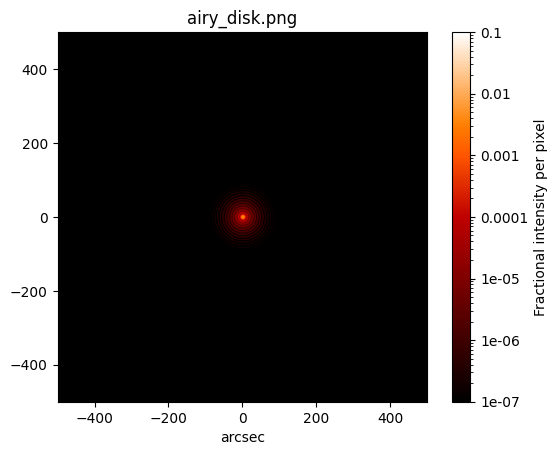

In [4]:
osys = poppy.OpticalSystem()
osys.add_pupil( poppy.CircularAperture(radius=9*u.mm))    # pupil radius in meters
osys.add_detector(pixelscale=1, fov_arcsec=1000.0)  # image plane coordinates in arcseconds
save_rgb_psf(osys, "airy_disk.png")

width: 2000, height: 2000
max values:  0.1247175905155018 0.1264349576085806 0.13012842973694205


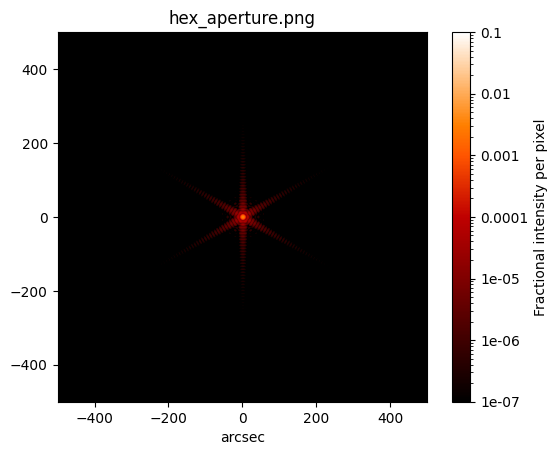

In [5]:
osys = poppy.OpticalSystem()
osys.add_pupil( poppy.HexagonAperture(diameter=18*u.mm))    # pupil radius in meters
osys.add_detector(pixelscale=1, fov_arcsec=1000.0)  # image plane coordinates in arcseconds
save_rgb_psf(osys, "hex_aperture.png")

width: 2048, height: 2048
max values:  0.5210981965065002 0.5156151652336121 0.5042197108268738


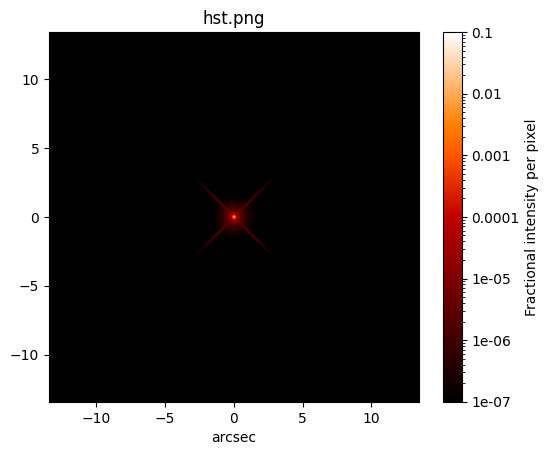

In [6]:
# HST example - Following example in PROPER Manual V2.0 page 49.
diam = 2.4 * u.m
fl_pri = 5.52085 * u.m
d_pri_sec = 4.907028205 * u.m
fl_sec = -0.6790325 * u.m
d_sec_to_focus = 6.3919974 * u.m

hst = poppy.FresnelOpticalSystem(pupil_diameter=2.4*u.m, npix=512, beam_ratio=0.25)
m1 = poppy.QuadraticLens(fl_pri, name='Primary')
m2 = poppy.QuadraticLens(fl_sec, name='Secondary')

hst.add_optic(poppy.CircularAperture(radius=diam.value/2))
hst.add_optic(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hst.add_optic(m1)
hst.add_optic(m2, distance=d_pri_sec)
hst.add_optic(poppy.ScalarTransmission(planetype=poppy.fresnel.PlaneType.image, name='focus'), distance=d_sec_to_focus);
save_rgb_psf(hst, "hst.png")